# Модули

In [100]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, log_loss
from sklearn.metrics import confusion_matrix, classification_report  

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight

import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
    
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns
import plotly.express as ex

%matplotlib inline
mpl.rcParams['font.family'] = 'Verdana'
plt.rcParams['xtick.labelsize'] = 10
rcParams['figure.figsize'] = 15, 10
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

dateparser = lambda x: pd.to_datetime(x, format='%d.%m.%y', errors='coerce')
dateparser_big_year = lambda x: pd.to_datetime(x, format='%d.%m.%Y', errors='coerce')

# Подгружаем данные 

In [2]:
innitial_pays = pd.read_csv('pays.csv', dtype={'hash_inn_kt': str, 'hash_inn_dt': str})
inn_info = pd.read_csv('inn_info_public.csv', dtype={'hash_inn': str, 'region': str, 'okved2': str})

# EDA

In [3]:
print('PAYS')
print('Количество записей: ', innitial_pays.shape[0])
print('Количество уникальных ИНН отправителей: ', innitial_pays['hash_inn_kt'].nunique())
print('Количество уникальных ИНН получателей: ', innitial_pays['hash_inn_dt'].nunique())
print('\nПропуски: ')
print(innitial_pays.isna().sum())

print('\nINN INFO')
print('Количество записей: ', inn_info.shape[0])
print('Количество уникальных ИНН: ', inn_info['hash_inn'].nunique())
print('\nПропуски: ')
print(inn_info.isna().sum())

PAYS
Количество записей:  5430150
Количество уникальных ИНН отправителей:  152160
Количество уникальных ИНН получателей:  189772

Пропуски: 
hash_inn_kt       0
hash_inn_dt       0
week              0
count             0
sum            1125
dtype: int64

INN INFO
Количество записей:  240069
Количество уникальных ИНН:  240069

Пропуски: 
hash_inn     0
okved2       0
region       0
is_public    0
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.



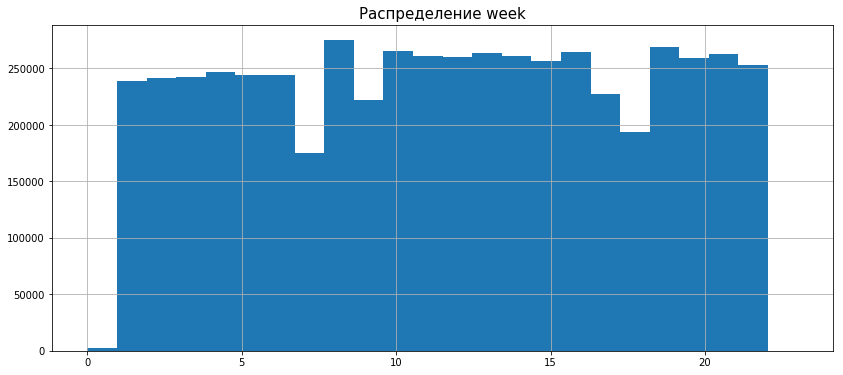

In [4]:
plt.figure(figsize=(14, 6))
plt.title('Распределение week', fontsize=15)
innitial_pays['week'].hist(bins=24);

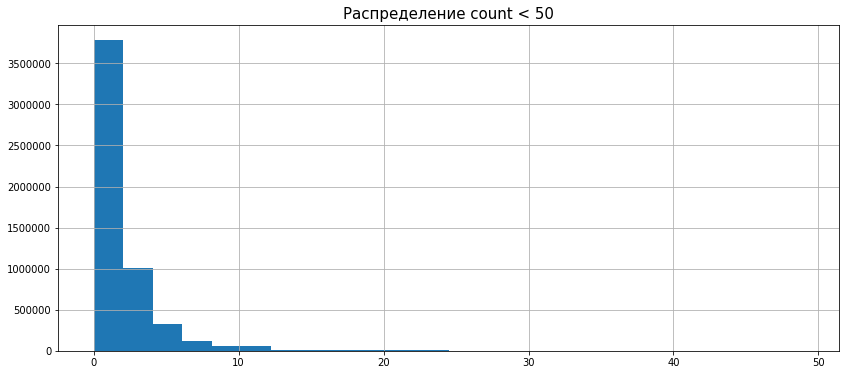

In [5]:
plt.figure(figsize=(14, 6))
plt.title('Распределение count < 50', fontsize=15)
innitial_pays[innitial_pays['count'] < 50]['count'].hist(bins=24);

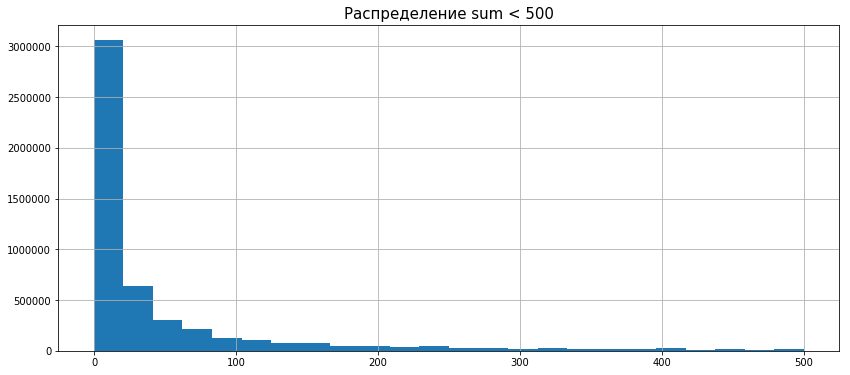

In [6]:
plt.figure(figsize=(14, 6))
plt.title('Распределение sum < 500', fontsize=15)
innitial_pays[innitial_pays['sum'] < 500]['sum'].hist(bins=24);

In [7]:
innitial_pays[innitial_pays['sum'].isnull()]

,hash_inn_kt,hash_inn_dt,week,count,sum
2400,263,263,12,0,NaN
2401,263,263,13,0,NaN
2402,263,263,14,0,NaN
73323,3430,3430,19,0,NaN
74124,3493,3493,8,0,NaN
...,...,...,...,...,...
5402624,259374,259374,16,0,NaN
5402625,259374,259374,20,0,NaN
5408484,259705,259705,16,0,NaN
5424576,260125,260125,6,0,NaN


In [8]:
innitial_pays['sum'] = innitial_pays['sum'].fillna(0)

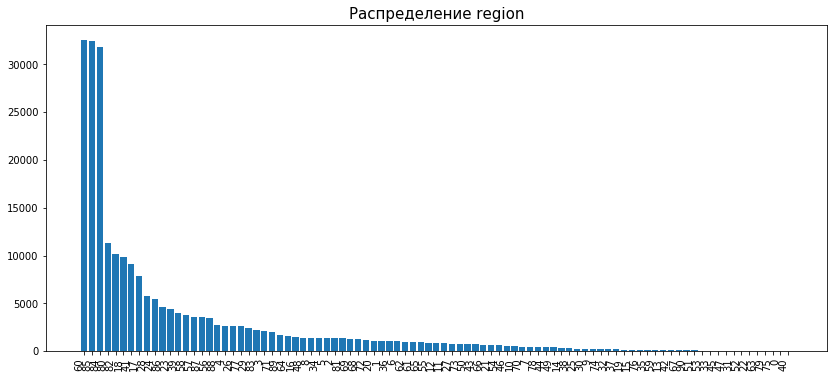

In [9]:
plt.figure(figsize=(14, 6))
plt.title('Распределение region', fontsize=15)
plt.xticks(rotation=90, ha='right')
plt.bar(x=inn_info['region'].value_counts().index.tolist(), height=inn_info['region'].value_counts());

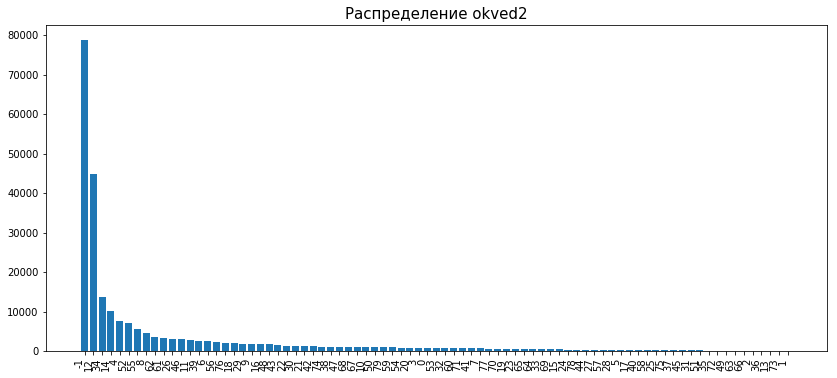

In [10]:
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90, ha='right')
plt.title('Распределение okved2', fontsize=15)
plt.bar(x=inn_info['okved2'].value_counts().index.tolist(), height=inn_info['okved2'].value_counts());

# Генерация фичей

## Добавление в обучающую выборку ИНН, у которых нет исходящих платежей

1. Добавляю регионы отправителя и получателя для каждой записи в innitial_pays
2. Группирую по ИНН отправителя и получателя и все данные записываю в списки для уникальных ИНН

Все фичи генерируются на основе данных об отправленных платежей и полученных, везде снизу постфикс _out - оправленные, _in - полученные

In [3]:
set_kt = set(innitial_pays['hash_inn_kt'].values)
set_dt = set(innitial_pays['hash_inn_dt'].values)

dt_no_kt = pd.DataFrame()
dt_no_kt['hash_inn_kt'] = list(set_dt - set_kt)
dt_no_kt['hash_inn_dt'] = np.nan
dt_no_kt['week'] = np.nan
dt_no_kt['count'] = np.nan
dt_no_kt['sum'] = np.nan

pays = innitial_pays.append(dt_no_kt, ignore_index=True)

# добавление региона
pays = pays.merge(inn_info[['hash_inn', 'region']], left_on='hash_inn_kt', right_on='hash_inn', how='left')
pays = pays.merge(inn_info[['hash_inn', 'region']], left_on='hash_inn_dt', right_on='hash_inn', how='left')

pays.rename(columns={'region_x': 'region_kt', 'region_y': 'region_dt'}, inplace=True)
pays.drop(['hash_inn_x', 'hash_inn_y'], axis=1, inplace=True)

In [4]:
# группиовка по ИНН
pays_out = pays.groupby('hash_inn_kt', as_index=False) \
                                       .agg({'region_kt': 'first',
                                             'week': lambda x: list(x), 
                                             'count': lambda x: list(x), 
                                             'sum': lambda x: list(x),
                                             'hash_inn_dt': lambda x: list(x),
                                             'region_dt': lambda x: list(x)})

pays_in = pays.groupby('hash_inn_dt', as_index=False) \
                                       .agg({'week': lambda x: list(x), 
                                             'count': lambda x: list(x), 
                                             'sum': lambda x: list(x), 
                                             'hash_inn_kt': lambda x: list(x),
                                             'region_kt': lambda x: list(x)})

# список категориальных фич
cat_features = []
cat_features.append('region_kt')

## hash_inn_kt and hash_inn_dt
Создание фичи - количество уникальных ИНН

In [5]:
pays_out['hash_inn_dt_unique'] = pays_out['hash_inn_dt'].apply(np.unique)
pays_in['hash_inn_kt_unique'] = pays_in['hash_inn_kt'].apply(np.unique)

## week
Создание фичей:
1. наличие платежа на каждую неделю
2. количество уникальных месяцев
3. статистики - min, max, sum, mean, std, median, len для списка из разниц в уникальных неделях
4. статистики - min, max, sum, mean, std, median, len для списка уникальных неделей
5. статистики - mean, std, median для списка, состоящего из изначальных неделей 

In [6]:
for i in range(0, 24):
    pays_out['is_' + str(i) + '_week_out'] = pays_out['week'].apply(lambda x: 1 if i in x else 0)
    pays_in['is_' + str(i) + '_week_in'] = pays_in['week'].apply(lambda x: 1 if i in x else 0)

pays_out['unique_week_out'] = pays_out['week'].apply(np.unique) \
                                              .apply(np.sort)
pays_in['unique_week_in'] = pays_in['week'].apply(np.unique) \
                                              .apply(np.sort)

pays_out['unique_week_out_diff'] = pays_out['unique_week_out'].apply(np.diff)
pays_in['unique_week_in_diff'] = pays_in['unique_week_in'].apply(np.diff)

# статистики
for function in [np.min, np.max, np.sum, np.mean, np.std, np.median, len]:
    pays_out['unique_week_out_diff_' + function.__name__]  = pays_out['unique_week_out_diff'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    pays_out['unique_week_out_' + function.__name__]  = pays_out['unique_week_out'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    
    pays_in['unique_week_in_diff_' + function.__name__]  = pays_in['unique_week_in_diff'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    pays_in['unique_week_in_' + function.__name__]  = pays_in['unique_week_in'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    
for function in [np.mean, np.std, np.median]:
    pays_out['week_out_' + function.__name__] = pays_out['week'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    
    pays_in['week_in_' + function.__name__] = pays_in['week'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))

## count
1. статистики для списка из count
2. количество платежей, где количество [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [7]:
for function in [np.min, np.max, np.sum, np.mean, np.std, np.median, len]:
    pays_out['count_out_' + function.__name__] = pays_out['count'].apply(function)
    pays_in['count_in_' + function.__name__] = pays_in['count'].apply(function)

for i in range(0, 11):
    pays_out['count_out_' + str(i)] = pays_out['count'].apply(lambda x: x.count(i))
    pays_in['count_in_' + str(i)] = pays_in['count'].apply(lambda x: x.count(i))

## sum
1. статистики для списка из sum
2. количество нулей в суммах
3. статистики по отрицательным суммам
4. статистики по положительным суммам
5. количество платежей с суммами в диапозонах

In [8]:
for function in [np.min, np.max, np.sum, np.mean, np.std, np.median]:
    pays_out['sum_out_' + function.__name__] = pays_out['sum'].apply(function)
    pays_in['sum_in_' + function.__name__] = pays_in['sum'].apply(function)

    
pays_out['sum_out_count_zero'] = pays_out['sum'].apply(lambda x: x.count(0))
pays_in['sum_in_count_zero'] = pays_in['sum'].apply(lambda x: x.count(0))


pays_out['negative_sum'] = pays_out['sum'].apply(lambda sums: [x for x in sums if x < 0])
pays_out['positive_sum'] = pays_out['sum'].apply(lambda sums: [x for x in sums if x > 0])

pays_in['negative_sum'] = pays_in['sum'].apply(lambda sums: [x for x in sums if x < 0])
pays_in['positive_sum'] = pays_in['sum'].apply(lambda sums: [x for x in sums if x > 0])

for function in [np.min, np.max, np.sum, np.mean, np.std, np.median, len]:
    pays_out['sum_out_negative_' + function.__name__] = pays_out['negative_sum'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    pays_in['sum_in_negative_' + function.__name__] = pays_in['negative_sum'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))

for function in [np.min, np.max, np.sum, np.mean, np.std, np.median, len]:
    pays_out['sum_out_positive_' + function.__name__] = pays_out['positive_sum'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))
    pays_in['sum_in_positive_' + function.__name__] = pays_in['positive_sum'].apply(
        lambda x: np.nan if len(x) == 0 else function(x))

    
for bound in [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 10], 
              [10, 100], [100, 1000], [1000, 10000], [10000, 100000]]:
    pays_out['sum_out_from_' + str(bound[0]) + '_to_' + str(bound[1])] = pays_out['sum'].apply(
        lambda x: ((np.array(x) >= bound[0]) * (np.array(x) < bound[1])).sum())
    pays_in['sum_in_from_' + str(bound[0]) + '_to_' + str(bound[1])] = pays_in['sum'].apply(
        lambda x: ((np.array(x) >= bound[0]) * (np.array(x) < bound[1])).sum())

## region_dt
1. количество уникальных регионов получателей
2. топ 5 по количеству регионов с названиями регионов

In [9]:
pays_out['region_dt_unique'] = pays_out['region_dt'].apply(np.unique)
pays_in['region_kt_unique'] = pays_in['region_kt'].apply(np.unique)

pays_out['region_dt_unique_count'] = pays_out['region_dt_unique'].apply(
    lambda x: np.nan if len(x) == 0 else len(x))
pays_in['region_kt_unique_count'] = pays_in['region_kt_unique'].apply(
    lambda x: np.nan if len(x) == 0 else len(x))

pays_out['region_dt_counter'] = pays_out['region_dt'].apply(
                                                    lambda region_dts: Counter(region_dts).most_common()) 
pays_in['region_kt_counter'] = pays_in['region_kt'].apply(
                                                    lambda region_dts: Counter(region_dts).most_common()) 

for i in range(5):
    try:
        pays_out['region_dt_' + str(i+1) + '_contractor'] = pays_out['region_dt_counter'].apply(
            lambda x: np.nan if len(x) < i+1 else x[i][0])
        pays_out['region_dt_' + str(i+1) + '_contractor_count'] = pays_out['region_dt_counter'].apply(
            lambda x: np.nan if len(x) < i+1 or str(x[i][0]) == 'nan' else x[i][1])
    except Exception as e:
#         print(e)
        pays_out['region_dt_' + str(i+1) + '_contractor'] = np.nan
        pays_out['region_dt_' + str(i+1) + '_contractor_count'] = np.nan  
        
    cat_features.append('region_dt_' + str(i+1) + '_contractor')
    
    
for i in range(5):
    try:
        pays_in['region_kt_' + str(i+1) + '_contractor'] = pays_in['region_kt_counter'].apply(
            lambda x: np.nan if len(x) < i+1 else x[i][0])
        pays_in['region_kt_' + str(i+1) + '_contractor_count'] = pays_in['region_kt_counter'].apply(
            lambda x: np.nan if len(x) < i+1 or str(x[i][0]) == 'nan' else x[i][1])
    except Exception as e:
#         print(e)
        pays_in['region_kt_' + str(i+1) + '_contractor'] = np.nan
        pays_in['region_kt_' + str(i+1) + '_contractor_count'] = np.nan  
        
    cat_features.append('region_kt_' + str(i+1) + '_contractor')

## weekly
1. Агрегация по ИНН и неделе и создание списков, как выше
2. количество платежей самому себе
3. количество совпадающих регионов
4. количество уникальных регионов
5. количество уникальных ИНН отпраителей и получателей
6. использвание pivot, все данные для ИНН теперь в одной строке в разрезе недели
7. стаитистики по всем показателям из пункта 6

In [14]:
# группировка по ИНН
pays_date_out = pays.groupby(['hash_inn_kt', 'week'], as_index=False).agg({'count': sum,
                                                           'sum': sum,
                                                           'hash_inn_dt': lambda x: list(x),
                                                           'region_dt': lambda x: list(x),
                                                           'region_kt': 'first'})

pays_date_in = pays.groupby(['hash_inn_dt', 'week'], as_index=False).agg({'count': sum,
                                                           'sum': sum,
                                                           'hash_inn_kt': lambda x: list(x),
                                                           'region_kt': lambda x: list(x),
                                                           'region_dt': 'first'})

pays_date_out['self_pays_weekly'] = pays_date_out.apply(
    lambda x: x['hash_inn_dt'].count(x['hash_inn_kt']), axis=1)

pays_date_out['self_region_out_weekly'] = pays_date_out.apply(
    lambda x: x['region_dt'].count(x['region_kt']), axis=1)

pays_date_in['self_region_in_weekly'] = pays_date_in.apply(
    lambda x: x['region_kt'].count(x['region_dt']), axis=1)

pays_date_out['unique_region_out_weekly'] = pays_date_out['region_dt'].apply(np.unique).apply(len)
pays_date_in['unique_region_in_weekly'] = pays_date_in['region_kt'].apply(np.unique).apply(len)

pays_date_out['unique_hash_inn_dt_out_weekly'] = pays_date_out['hash_inn_dt'].apply(np.unique).apply(len)
pays_date_in['unique_hash_inn_kt_in_weekly'] = pays_date_in['hash_inn_kt'].apply(np.unique).apply(len)


# все данные в разрезе недели в строке
pays_date_out = pays_date_out.pivot(index='hash_inn_kt', columns='week', 
                                    values=['count', 'sum', 'self_pays_weekly',
                                            'self_region_out_weekly', 'unique_region_out_weekly',
                                            'unique_hash_inn_dt_out_weekly'])

pays_date_in = pays_date_in.pivot(index='hash_inn_dt', columns='week', 
                                    values=['count', 'sum',
                                            'self_region_in_weekly', 'unique_region_in_weekly',
                                            'unique_hash_inn_kt_in_weekly'])


# заполнение нулями пропуски
pays_date_out = pays_date_out.reset_index().fillna(0)
pays_date_in = pays_date_in.reset_index().fillna(0)


# статистики по всем показателям
for function in [np.min, np.max, np.mean, np.std, np.median]:
    pays_date_out['weekly_count_out_' + function.__name__] = pays_date_out['count'].apply(function, axis=1)
    pays_date_in['weekly_count_in_' + function.__name__] = pays_date_in['count'].apply(function, axis=1)
    
    pays_date_out['weekly_sum_out_' + function.__name__] = pays_date_out['sum'].apply(function, axis=1)
    pays_date_in['weekly_sum_in_' + function.__name__] = pays_date_in['sum'].apply(function, axis=1)

for function in [np.min, np.max, np.mean, np.std, np.median, np.sum]:
    pays_date_out['weekly_self_pays_' + function.__name__] = pays_date_out['self_pays_weekly'].apply(function, axis=1)

    pays_date_out['weekly_self_region_out_' + function.__name__] = pays_date_out['self_region_out_weekly'].apply(function, axis=1)
    pays_date_in['weekly_self_region_in_' + function.__name__] = pays_date_in['self_region_in_weekly'].apply(function, axis=1)
    
    pays_date_out['weekly_unique_region_out_' + function.__name__] = pays_date_out['unique_region_out_weekly'].apply(function, axis=1)
    pays_date_in['weekly_unique_region_in_' + function.__name__] = pays_date_in['unique_region_in_weekly'].apply(function, axis=1)
    
    pays_date_out['weekly_unique_hash_inn_dt_out_' + function.__name__] = pays_date_out['unique_hash_inn_dt_out_weekly'].apply(function, axis=1)
    pays_date_in['weekly_unique_hash_inn_kt_in_' + function.__name__] = pays_date_in['unique_hash_inn_kt_in_weekly'].apply(function, axis=1)
    

## monthly
Все тоже самое что и выше только в разрезе месяца - 4 недели

In [23]:
# словари для хранения названий столбцов
monthly_features_out = {}
monthly_features_in = {}

for column_name in ['count', 'sum', 'self_pays_weekly', 'self_region_out_weekly', 
                    'unique_region_out_weekly', 'unique_hash_inn_dt_out_weekly']:
    pays_date_out[column_name + '_1_month_out'] = pays_date_out[column_name][range(1, 5)].apply(sum, axis=1)
    pays_date_out[column_name + '_2_month_out'] = pays_date_out[column_name][range(5, 9)].apply(sum, axis=1)
    pays_date_out[column_name + '_3_month_out'] = pays_date_out[column_name][range(9, 13)].apply(sum, axis=1)
    pays_date_out[column_name + '_4_month_out'] = pays_date_out[column_name][range(13, 17)].apply(sum, axis=1)
    pays_date_out[column_name + '_5_month_out'] = pays_date_out[column_name][range(17, 21)].apply(sum, axis=1)
    pays_date_out[column_name + '_6_month_out'] = pays_date_out[column_name][range(21, 23)].apply(sum, axis=1)
    
    monthly_features_out[column_name] = [column_name + '_1_month_out', 
                                         column_name + '_2_month_out', 
                                         column_name + '_3_month_out', 
                                         column_name + '_4_month_out',
                                         column_name + '_5_month_out', 
                                         column_name + '_6_month_out']
    
for column_name in ['count', 'sum', 'self_region_in_weekly', 
                    'unique_region_in_weekly', 'unique_hash_inn_kt_in_weekly']:
    pays_date_in[column_name + '_1_month_in'] = pays_date_in[column_name][range(1, 5)].apply(sum, axis=1)
    pays_date_in[column_name + '_2_month_in'] = pays_date_in[column_name][range(5, 9)].apply(sum, axis=1)
    pays_date_in[column_name + '_3_month_in'] = pays_date_in[column_name][range(9, 13)].apply(sum, axis=1)
    pays_date_in[column_name + '_4_month_in'] = pays_date_in[column_name][range(13, 17)].apply(sum, axis=1)
    pays_date_in[column_name + '_5_month_in'] = pays_date_in[column_name][range(17, 21)].apply(sum, axis=1)
    pays_date_in[column_name + '_6_month_in'] = pays_date_in[column_name][range(21, 23)].apply(sum, axis=1)

    monthly_features_in[column_name] = [column_name + '_1_month_in', 
                                        column_name + '_2_month_in', 
                                        column_name + '_3_month_in', 
                                        column_name + '_4_month_in',
                                        column_name + '_5_month_in', 
                                        column_name + '_6_month_in']
    
    
# статистики по показателям в разреезе месяца
for function in [np.min, np.max, np.mean, np.std, np.median]:
    pays_date_out['monthly_count_out_' + function.__name__] = pays_date_out[monthly_features_out['count']].apply(function, axis=1)
    pays_date_in['monthly_count_in_' + function.__name__] = pays_date_in[monthly_features_in['count']].apply(function, axis=1)
    
    pays_date_out['monthly_sum_out_' + function.__name__] = pays_date_out[monthly_features_out['sum']].apply(function, axis=1)
    pays_date_in['monthly_sum_in_' + function.__name__] = pays_date_in[monthly_features_in['sum']].apply(function, axis=1)

for function in [np.min, np.max, np.mean, np.std, np.median, np.sum]:
    pays_date_out['monthly_self_pays_' + function.__name__] = pays_date_out[monthly_features_out['self_pays_weekly']].apply(function, axis=1)
    pays_date_out['monthly_self_region_out_' + function.__name__] = pays_date_out[monthly_features_out['self_region_out_weekly']].apply(function, axis=1)
    pays_date_in['monthly_self_region_in_' + function.__name__] = pays_date_in[monthly_features_in['self_region_in_weekly']].apply(function, axis=1)
    
    pays_date_out['monthly_unique_region_out_' + function.__name__] = pays_date_out[monthly_features_out['unique_region_out_weekly']].apply(function, axis=1)
    pays_date_in['monthly_unique_region_in_' + function.__name__] = pays_date_in[monthly_features_in['unique_region_in_weekly']].apply(function, axis=1)
    
    pays_date_out['monthly_unique_hash_inn_dt_out_' + function.__name__] = pays_date_out[monthly_features_out['unique_hash_inn_dt_out_weekly']].apply(function, axis=1)
    pays_date_in['monthly_unique_hash_inn_kt_in_' + function.__name__] = pays_date_in[monthly_features_in['unique_hash_inn_kt_in_weekly']].apply(function, axis=1)
    

# Модель

In [39]:
# join всех таблиц
features = pays_out.merge(pays_in, left_on='hash_inn_kt', right_on='hash_inn_dt', how='left')
features = features.merge(pays_date_out, left_on='hash_inn_kt_x', right_on='hash_inn_kt', how='left')
features = features.merge(pays_date_in, left_on='hash_inn_kt_x', right_on='hash_inn_dt', how='left')

features.drop(['hash_inn_dt_x', 'hash_inn_dt_y', 'hash_inn_kt_y', 
               ('hash_inn_kt', ''), ('hash_inn_dt', '')], axis=1, inplace=True)

# выбрасываю ненужные колонки со списками
not_needed_columns = []
for columns in features.columns.tolist():
    if isinstance(features.loc[0][columns], list) or isinstance(features.loc[0][columns], np.ndarray):
        not_needed_columns.append(columns)

features.rename(columns={'region_kt_x': 'region_kt', 'hash_inn_kt_x': 'hash_inn_kt'}, inplace=True)
features.drop(not_needed_columns, axis=1, inplace=True)

# список с названиями числовых фич
cont_features = set(features.columns.tolist()) - set(cat_features)
cont_features = list(cont_features)

In [53]:
# features.to_csv('features.csv', index=False)
# features = pd.read_csv('features.csv', dtype={'hash_inn_kt': str})

import re
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [98]:
# добавляем таргет
data = features.merge(inn_info[['hash_inn', 'okved2']], left_on='hash_inn_kt', right_on='hash_inn')
data.drop(['hash_inn'], axis=1, inplace=True)
data.set_index('hash_inn_kt', inplace=True)

# меняем тип категориальных фич
for cat_column in cat_features:
    data[cat_column] = data[cat_column].astype('category')
    data[cat_column] = data[cat_column].cat.add_categories('none')

# разделение для submission
submission = data[data['okved2'] == '-1']
data = data[data['okved2'] != '-1']

X = data.drop('okved2', axis=1)
y = data['okved2'].astype(int)

# X[cont_features] = X[cont_features].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)

print('Количество фичей: ', len(X_train.columns.tolist()))
print('\n')
print(X_train.columns.tolist())

Количество фичей:  657


['region_kt', 'is_0_week_out', 'is_1_week_out', 'is_2_week_out', 'is_3_week_out', 'is_4_week_out', 'is_5_week_out', 'is_6_week_out', 'is_7_week_out', 'is_8_week_out', 'is_9_week_out', 'is_10_week_out', 'is_11_week_out', 'is_12_week_out', 'is_13_week_out', 'is_14_week_out', 'is_15_week_out', 'is_16_week_out', 'is_17_week_out', 'is_18_week_out', 'is_19_week_out', 'is_20_week_out', 'is_21_week_out', 'is_22_week_out', 'is_23_week_out', 'unique_week_out_diff_amin', 'unique_week_out_amin', 'unique_week_out_diff_amax', 'unique_week_out_amax', 'unique_week_out_diff_sum', 'unique_week_out_sum', 'unique_week_out_diff_mean', 'unique_week_out_mean', 'unique_week_out_diff_std', 'unique_week_out_std', 'unique_week_out_diff_median', 'unique_week_out_median', 'unique_week_out_diff_len', 'unique_week_out_len', 'week_out_mean', 'week_out_std', 'week_out_median', 'count_out_amin', 'count_out_amax', 'count_out_sum', 'count_out_mean', 'count_out_std', 'count_out_median', 'count_out

## SMOTE

In [60]:
# smote = SMOTE('not majority')
# X_sm, y_sm =  smote.fit_sample(X_nm, y_nm)
# print('Добавлено в обучение: ', y_sm.shape[0] - y_nm.shape[0])

# X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.125)

## class_weight

In [61]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

## LightGBM

In [63]:
# Классификация
train_data = lgb.Dataset(X_train,
                         label=y_train,
                         free_raw_data=False)
val_data = lgb.Dataset(X_val, 
                       label=y_val,
                       free_raw_data=False)

params = {
            'objective': 'multiclass',
            'num_class': 80,
            'metric': 'multi_logloss',
            'num_leaves': 100,
            'learning_rate': 0.01,
            'num_iterations': 500,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'verbose': 0,
            'n_jobs': 16,
            'max_depth': 50,
            'max_bin': 256, 
            'min_data_in_leaf': 500,
            'min_child_samples': 100,
            'class_weight': class_weights
         }

lgbm_classificator = lgb.train(params,
                               train_data,
                               num_boost_round=1200,
                               early_stopping_rounds=30,
                               valid_sets=val_data,
                               verbose_eval=10)

print('Закончен расчет модели классификации')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 30 rounds
[10]	valid_0's multi_logloss: 3.19371
[20]	valid_0's multi_logloss: 3.15838
[30]	valid_0's multi_logloss: 3.12866
[40]	valid_0's multi_logloss: 3.10294
[50]	valid_0's multi_logloss: 3.08039
[60]	valid_0's multi_logloss: 3.06029
[70]	valid_0's multi_logloss: 3.04248
[80]	valid_0's multi_logloss: 3.0266
[90]	valid_0's multi_logloss: 3.01232
[100]	valid_0's multi_logloss: 2.99937
[110]	valid_0's multi_logloss: 2.98766
[120]	valid_0's multi_logloss: 2.97697
[130]	valid_0's multi_logloss: 2.96712
[140]	valid_0's multi_logloss: 2.95815
[150]	valid_0's multi_logloss: 2.94994
[160]	valid_0's multi_logloss: 2.94253
[170]	valid_0's multi_logloss: 2.93558
[180]	valid_0's multi_logloss: 2.92921
[190]	valid_0's multi_logloss: 2.92307
[200]	valid_0's multi_logloss: 2.91747
[210]	valid_0's multi_logloss: 2.91229
[220]	valid_0's multi_logloss: 2.90764
[230]	valid_0's multi_logloss: 2.90329
[240]	valid_0's multi_logloss: 2.89936
[250]	valid_0

# Предсказание

In [82]:
y_pred = lgbm_classificator.predict(X_test, num_iteration=lgbm_classificator.best_iteration)
y_pred_argmax = [np.argmax(i) for i in y_pred]

print(classification_report(y_test, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        21
           3       0.50      0.01      0.02       175
           4       0.37      0.02      0.04      1536
           5       0.00      0.00      0.00        44
           6       0.36      0.06      0.11       493
           7       0.00      0.00      0.00       139
           8       0.56      0.01      0.02       936
           9       0.17      0.00      0.00       399
          10       0.00      0.00      0.00       172
          11       0.37      0.17      0.23       550
          12       0.33      0.93      0.48      8978
          13       0.00      0.00      0.00        11
          14       0.32      0.46      0.38      2019
          15       0.00      0.00      0.00        77
          16       0.20      0.02      0.03       379
          17       1.00    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# precision recall curve

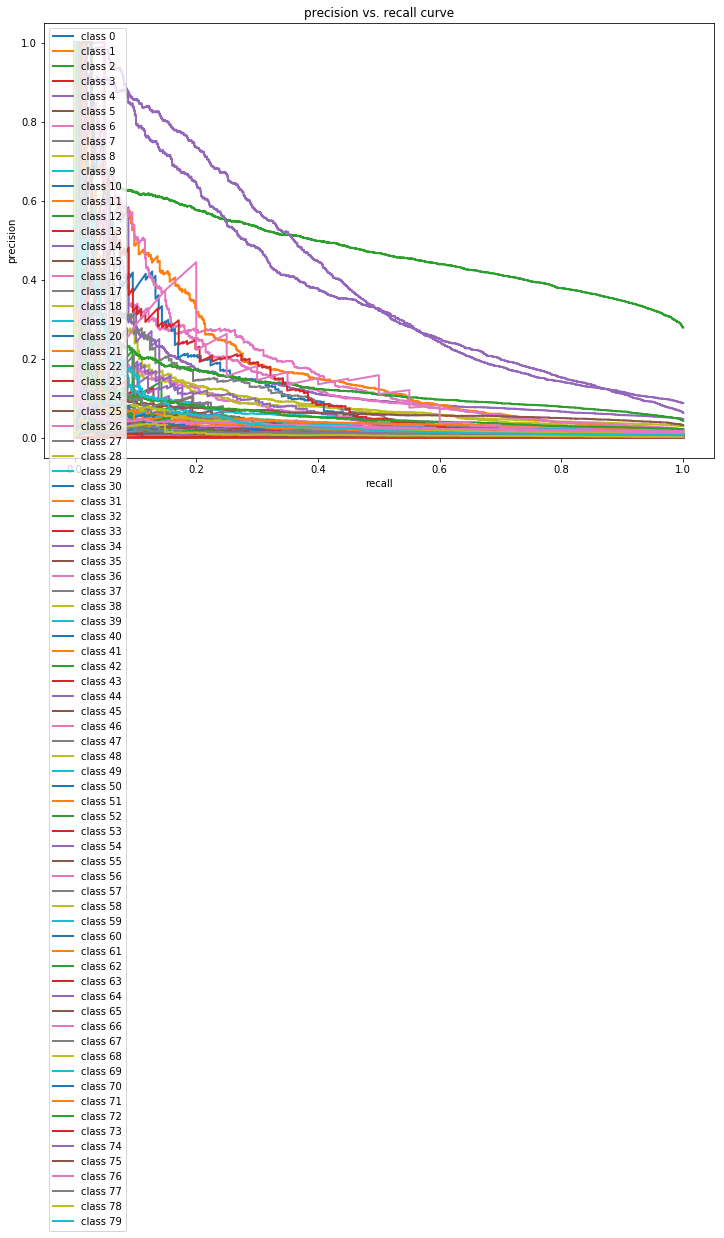

In [92]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

plt.figure(figsize=(12 ,8))
precision = dict()
recall = dict()
n_classes = y.nunique()
y_test_binarize = label_binarize(y_test, classes=[*range(n_classes)])
average_precision = average_precision_score(y_test_binarize[:, i], y_pred[:, i])

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarize[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# ROC AUC

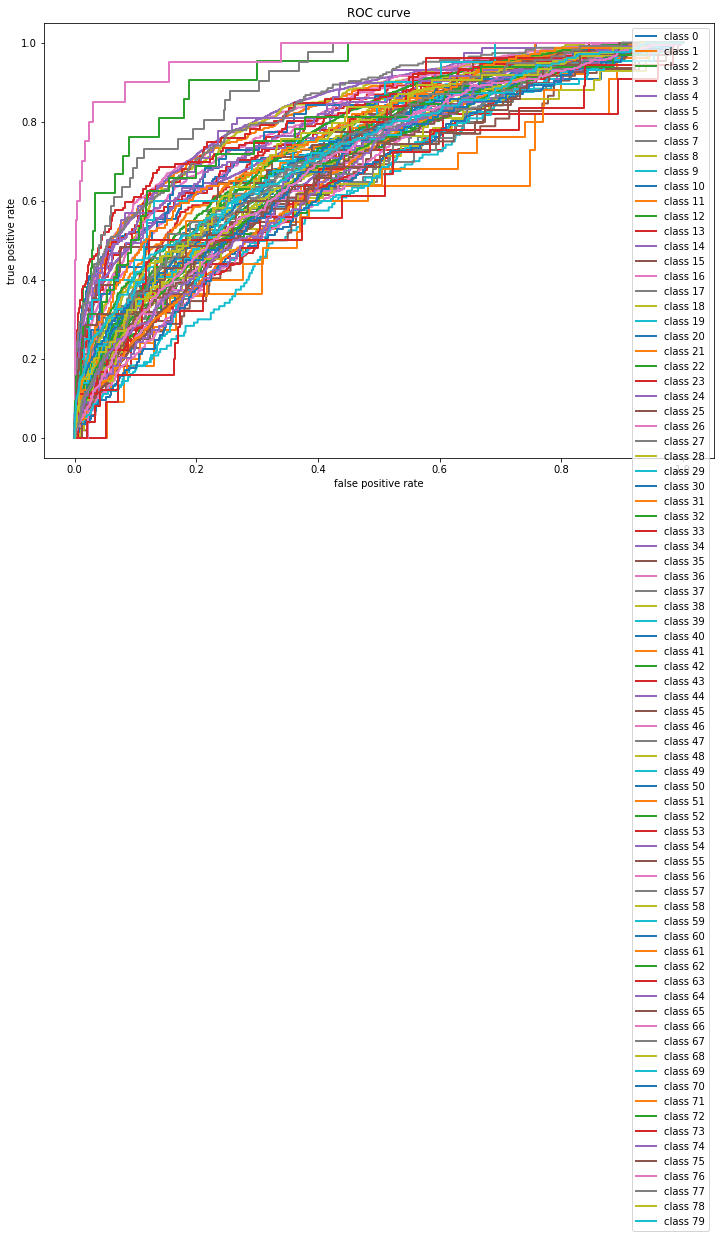

In [91]:
plt.figure(figsize=(12 ,8))
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i],
                                  y_pred[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

# Confusion matrix

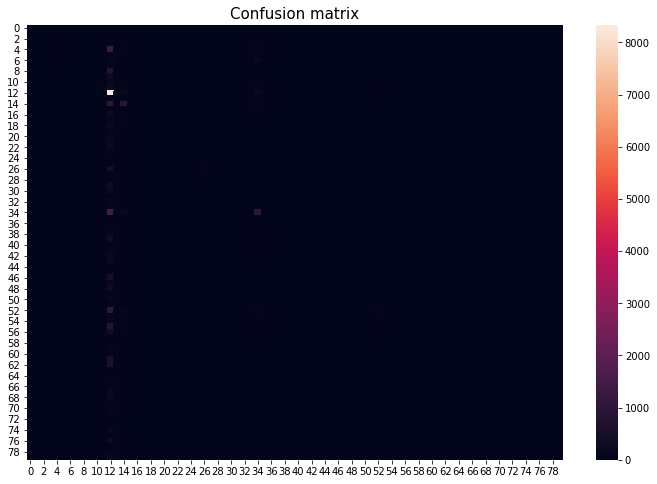

In [94]:
plt.figure(figsize=(12 ,8))
plt.title('Confusion matrix', fontsize=15)
sns.heatmap(confusion_matrix(y_test, y_pred_argmax));

# Feature importance

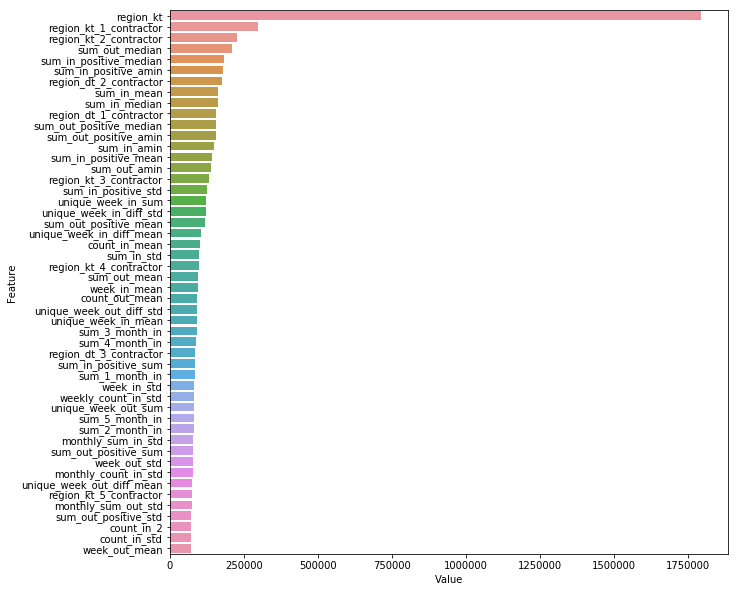

In [97]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_classificator.feature_importance(importance_type='gain'),  
                                      X_train.columns)),
                           columns=['Value', 'Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[:50]);

# Feature selection

In [103]:
feature_imp.sort_values(by='Value', ascending=False)[:100]

,Value,Feature
656,1.796260e+06,region_kt
655,2.967616e+05,region_kt_1_contractor
654,2.271774e+05,region_kt_2_contractor
653,2.089380e+05,sum_out_median
652,1.825791e+05,sum_in_positive_median
...,...,...
561,4.662868e+04,monthly_unique_region_out_std
560,4.612207e+04,monthly_unique_hash_inn_kt_in_std
559,4.548387e+04,unique_week_out_amin
558,4.521676e+04,count_out_median


# Submission

In [73]:
sub_X = submission.drop('okved2', axis=1)

y_pred = lgbm_classificator.predict(sub_X, num_iteration=lgbm_classificator.best_iteration)
y_pred_argmax = [np.argmax(i) for i in y_pred]

submission_file = pd.DataFrame()
submission_file['hash_inn'] = sub_X.index.tolist()
submission_file['y'] = y_pred_argmax

submission_file.to_csv('AlexanderRemizov-17072020-SberbankIndustry.csv', index=False)

In [106]:
import joblib
# save model
joblib.dump(lgbm_classificator, 'lgbm_classificator.pkl')
# load model
# lgbm_classificator = joblib.load('lgbm_classificator.pkl')

['lgbm_classificator.pkl']

# Другие модели

In [105]:
X = data.drop('okved2', axis=1)
y = data['okved2']

X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for model in [LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB(), SVC()]:
    print(str(model).split('(')[0])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))